<h1>Problem Statement</h1> 
<p><i>For easy reference</i></p>
<p>Objective: develop a model that recommends the best financial advisors for individual customers through various techniques such as recommendation systems, supervised learning models, or unsupervised learning models. Used to assign the most suitable financial advisors to customers.</p>

In [123]:
import pandas as pd 
import os #for reading files
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder
import seaborn as sns
import numpy as np
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from surprise import Dataset, Reader, SVD, accuracy
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
path = "./final_nus_datathon_dataset"

In [124]:
#!pip install pyarrow 
#^if you need to install pyarrow uncomment
# !pip3 install imbalanced-learn
# !pip3 install xgboost


<h3>Load Data</h3>

In [125]:
dfs = dict()
files = os.listdir(path)

print("Naming Convention:")
for i in range(len(files)):
    _,*filename,_,_ = files[i].split("_") 
    dfs[filename[0]] = pd.read_parquet(f"{path}/{files[i]}") 
    print("dfs[\"",filename[0],"\"]", ":", files[i])
               


Naming Convention:
dfs[" policy "] : nus_policy_info_df.parquet
dfs[" client "] : nus_client_info_df.parquet
dfs[" final "] : sample_final_modelling_df.parquet
dfs[" agent "] : nus_agent_info_df.parquet


<h3>Description of Dataset</h3>
<p>I just put the table from the Problem Statemen docs under each respective dataset for easy ref</p>

In [126]:
dfs["policy"].head()

,chdrnum,agntnum,secuityno,occdate,annual_premium,product,flg_main,flg_rider,flg_inforce,flg_lapsed,flg_cancel,flg_expire,flg_converted,product_grp,cust_age_at_purchase_grp,cust_tenure_at_purchase_grp
0,PID:281,AIN:62,CIN:6957,2018-11-12,0.0,prod_8,1,0,1,0,0,0,1,PG:0,AG05_35to39,TNR2_lt1yr
1,PID:280,AIN:63,CIN:2161,2024-02-22,7.0,prod_8,1,0,1,0,0,0,1,PG:0,AG04_30to34,TNR4_4to8yr
2,PID:2577,AIN:63,CIN:16605,2024-08-28,423.0,prod_6,1,0,1,0,0,0,1,PG:0,AG08_50to54,TNR5_8yrup
3,PID:2578,AIN:63,CIN:16605,2024-08-27,217.0,prod_6,1,0,1,0,0,0,1,PG:0,AG08_50to54,TNR5_8yrup
4,PID:305,AIN:63,CIN:7917,2024-08-28,432.0,prod_6,1,0,1,0,0,0,1,PG:0,AG07_45to49,TNR4_4to8yr


<table>
<thead>
<tr><th>Column Name</th><th>Purpose</th></tr>
</thead>
<tbody>
<tr><td>chdrnum</td><td> unique identifier for policy</td></tr>
<tr><td>agntnum</td><td> unique identifier for agent</td></tr>
<tr><td>secuityno</td><td> unique identifier for customer</td></tr>
<tr><td>occdate</td><td> inception date of policy</td></tr>
<tr><td>annual_premium</td><td> annual premium</td></tr>
<tr><td>product</td><td> product of the policy</td></tr>
<tr><td>product_grp </td><td> product group of the policy</td></tr>
<tr><td>flg_main </td><td> flag indicating the main policyholder</td></tr>
<tr><td>flg_inforce </td><td> flag indicating a policy that is in force</td></tr>
<tr><td>flg_cancel </td><td> flag indicating a policy that is cancelled</td></tr>
<tr><td>flg_expire </td><td> flag indicating a policy that expired</td></tr>
<tr><td>flg_converted </td><td> flag indicating a policy that is converted</td></tr>
<tr><td>cust_age_purchase_grp</td><td> customer's age group at purchase</td></tr>
<tr><td>cust_teure_at_purchase_grp</td><td> customer's tenure at purchase</td></tr>
</tbody>
</table>

In [127]:
dfs["agent"].head()

,agntnum,agent_age,agent_gender,agent_marital,agent_tenure,cnt_converted,annual_premium_cnvrt,pct_lapsed,pct_cancel,pct_inforce,pct_prod_0_cnvrt,pct_prod_1_cnvrt,pct_prod_2_cnvrt,pct_prod_3_cnvrt,pct_prod_4_cnvrt,pct_prod_5_cnvrt,pct_prod_6_cnvrt,pct_prod_7_cnvrt,pct_prod_8_cnvrt,pct_prod_9_cnvrt,pct_SX0_unknown,pct_SX1_male,pct_SX2_female,pct_AG01_lt20,pct_AG02_20to24,pct_AG03_25to29,pct_AG04_30to34,pct_AG05_35to39,pct_AG06_40to44,pct_AG07_45to49,pct_AG08_50to54,pct_AG09_55to59,pct_AG10_60up,cluster,agent_product_expertise
0,AIN:9513,32.0,M,M,15.0,21.0,1.004900e+04,1.0,0.814954,0.000000,0.0,0.0,0.285714,0.0,0.523810,0.0,0.190476,0.0,0.000000,0.000000,0.0,0.333333,0.666667,0.000000,0.238095,0.142857,0.000000,0.000000,0.000000,0.000000,0.238095,0.142857,0.238095,3,"[prod_2, prod_6]"
1,AIN:4310,40.0,M,M,18.0,396.0,1.971080e+05,0.6,0.083937,0.429293,0.0,0.0,0.128788,0.0,0.005051,0.0,0.462121,0.0,0.292929,0.111111,0.0,0.601010,0.398990,0.012626,0.012626,0.131313,0.388889,0.116162,0.184343,0.083333,0.020202,0.040404,0.010101,6,[prod_6]
2,AIN:4302,39.0,F,M,40.0,853.0,5.106351e+05,0.3,0.017406,0.711606,0.0,0.0,0.242673,0.0,0.083236,0.0,0.436108,0.0,0.109027,0.128957,0.0,0.695193,0.304807,0.010551,0.030481,0.137163,0.144197,0.177022,0.311841,0.106682,0.036342,0.035170,0.010551,6,[prod_4]
3,AIN:4996,57.0,F,D,41.0,554.0,3.514724e+05,0.3,0.003623,0.584838,0.0,0.0,0.194946,0.0,0.083032,0.0,0.436823,0.0,0.061372,0.223827,0.0,0.397112,0.602888,0.018051,0.005415,0.009025,0.128159,0.108303,0.234657,0.162455,0.135379,0.160650,0.037906,6,"[prod_7, prod_9, prod_6, prod_0, prod_2]"
4,AIN:3457,38.0,M,M,62.0,1525.0,1.215380e+06,0.3,0.017523,0.640656,0.0,0.0,0.145574,0.0,0.047869,0.0,0.620328,0.0,0.114098,0.072131,0.0,0.626885,0.373115,0.013115,0.035410,0.069508,0.201311,0.215082,0.214426,0.108197,0.084590,0.043279,0.015082,6,"[prod_6, prod_8]"


<table>
<thead>
<tr><th>Column Name</th><th>Purpose</th></tr>
</thead>
<tbody>
<tr><td>agent_age</td><td> agent’s age </td></tr>
<tr><td>agent_gender</td><td> agent’s gender </td></tr>
<tr><td>agent_marital</td><td> agent’s marital status </td></tr>
<tr><td>agent_tenure</td><td> agent’s tenure with the company </td></tr>
<tr><td>cnt_converted</td><td> count of policies converted by agent </td></tr>
<tr><td>annual_premium_cnvrt</td><td> total annual premium from converted policies by agent </td></tr>
<tr><td>pct_lapsed</td><td> percentage of policies that are currently lapsed </td></tr>
<tr><td>pct_cancel</td><td> percentage of policies that are currently cancelled </td></tr>
<tr><td>pct_inforce</td><td> percentage of policies that are currently in force </td></tr>
<tr><td>Percentage of customers’ gender handled by the agent</td><td> pct_sx0_unknown, pct_sx1_male, pct_sx2_female </td></tr>

<tr><td>Percentage of products sold by agent</td><td> pct_prod_0_cnvrt, pct_prod_1_cnvrt, ..., pct_prod_9_cnvrt</td></tr>

<tr><td>Percentage of customers’ age groups handled by the agent</td><td> pct_ag01_lt20, pct_ag02_20to24, ..., pct_ag10_60up </td></tr>
<tr><td>cluster</td><td> an old segment that the agent belongs to </td></tr>
<tr><td>agent_product_expertise</td><td> a list of products the agent is comfortable selling (based on feedback) </td></tr>
</tbody>
</table>


In [128]:
dfs["client"].head()

,secuityno,cltsex,cltdob,marryd,race_desc_map,cltpcode,household_size,economic_status,family_size,household_size_grp,family_size_grp
0,CIN:14264,F,1993-02-17,M,Chinese,545686,1,76,56,HH1_lt40,FS3_40to60
1,CIN:7188,F,1977-06-15,M,Chinese,308364,72,96,90,HH2_40to80,FS5_80up
2,CIN:13608,F,1998-02-12,S,Chinese,387393,28,93,23,HH1_lt40,FS2_20to40
3,CIN:5087,F,1972-10-25,M,Chinese,640469,84,51,34,HH3_80to100,FS2_20to40
4,CIN:18531,M,1984-12-27,M,Others,763318,92,18,73,HH3_80to100,FS4_60to80


<table>
<thead>
<tr><th>Column Name</th><th>Purpose</th></tr>
</thead>
<tbody>
<tr><td>secuityno</td><td> unique identifier for customer</td></tr>
<tr><td>cltsex</td><td> gender of customer</td></tr>
<tr><td>cltdob</td><td> date of birth of customer</td></tr>
<tr><td>marryd</td><td> marital status of customer</td></tr>
<tr><td>race_desc_map</td><td> race of customer</td></tr>
<tr><td>cltpcode</td><td> customer postal code</td></tr>
<tr><td>household_size</td><td> household size (based on postal code)</td></tr>
<tr><td>economic_status</td><td> economic status (based on postal code)</td></tr>
<tr><td>family_size</td><td> family size (based on postal code)</td></tr>
<tr><td>household_size_grp</td><td> discretized household size of customer</td></tr>
<tr><td>family_size_grp</td><td> discretized family size of customer</td></tr>
</tbody>
</table>

In [129]:
#removing NAs
for name in dfs:
    rows_before = len(dfs[name])
    dfs[name] = dfs[name].dropna() 
    rows_after = len(dfs[name])
    print(f"Dataset '{name}': Before {rows_before} After {rows_after}")

print("complete")

Dataset 'policy': Before 29503 After 29503
Dataset 'client': Before 20000 After 19647
Dataset 'final': Before 29503 After 29477
Dataset 'agent': Before 10129 After 10117
complete


<h2>EDA for Client Dataframe</h2>
<p>Can explore one hot encoding</p>

In [130]:
dfs["client"].head(3)

,secuityno,cltsex,cltdob,marryd,race_desc_map,cltpcode,household_size,economic_status,family_size,household_size_grp,family_size_grp
0,CIN:14264,F,1993-02-17,M,Chinese,545686,1,76,56,HH1_lt40,FS3_40to60
1,CIN:7188,F,1977-06-15,M,Chinese,308364,72,96,90,HH2_40to80,FS5_80up
2,CIN:13608,F,1998-02-12,S,Chinese,387393,28,93,23,HH1_lt40,FS2_20to40


In [131]:
#Unique values per df
#Client 
print("Unique values per column in Client")
for col in ["marryd","household_size_grp","family_size_grp"]:
    print(len(dfs["client"][col].unique()), f"for {col}")
    print(dfs["client"][col].unique())
    print("-"*6)


Unique values per column in Client
6 for marryd
['M' 'S' 'D' 'U' 'W' 'P']
------
6 for household_size_grp
['HH1_lt40' 'HH2_40to80' 'HH3_80to100' 'HH4_100to120' 'HH5_120up'
 'HH0_missing']
------
6 for family_size_grp
['FS3_40to60' 'FS5_80up' 'FS2_20to40' 'FS4_60to80' 'FS1_lt20'
 'FS0_missing']
------


In [132]:
#Encode sex, marryd, race, HH_Size, Family_Size
dfs["client_encoded"] = dfs["client"].copy()
family_cat = [[ 'FS0_missing','FS1_lt20', 'FS2_20to40','FS3_40to60','FS4_60to80' ,'FS5_80up']]
household_cat = [['HH0_missing','HH1_lt40', 'HH2_40to80', 'HH3_80to100', 'HH4_100to120', 'HH5_120up']]

col = "household_size_grp"
encoder = OrdinalEncoder(categories=household_cat)
dfs["client_encoded"][f"{col}_encoded"] = encoder.fit_transform(dfs["client_encoded"][[col]])
col = "family_size_grp"
encoder = OrdinalEncoder(categories=family_cat)
dfs["client_encoded"][f"{col}_encoded"] = encoder.fit_transform(dfs["client_encoded"][[col]]) 
dfs["client_encoded"].drop(columns=["family_size_grp","household_size_grp"], inplace=True)


for col in ["cltsex","marryd","race_desc_map"]: 
    encoder = LabelEncoder()
    dfs["client_encoded"][f"{col}_encoded"] = encoder.fit_transform(dfs["client_encoded"][col])
    dfs["client_encoded"].drop(columns=[col],inplace=True)


In [133]:
dfs["client_encoded"].head(3)

,secuityno,cltdob,cltpcode,household_size,economic_status,family_size,household_size_grp_encoded,family_size_grp_encoded,cltsex_encoded,marryd_encoded,race_desc_map_encoded
0,CIN:14264,1993-02-17,545686,1,76,56,1.0,3.0,0,1,0
1,CIN:7188,1977-06-15,308364,72,96,90,2.0,5.0,0,1,0
2,CIN:13608,1998-02-12,387393,28,93,23,1.0,2.0,0,3,0


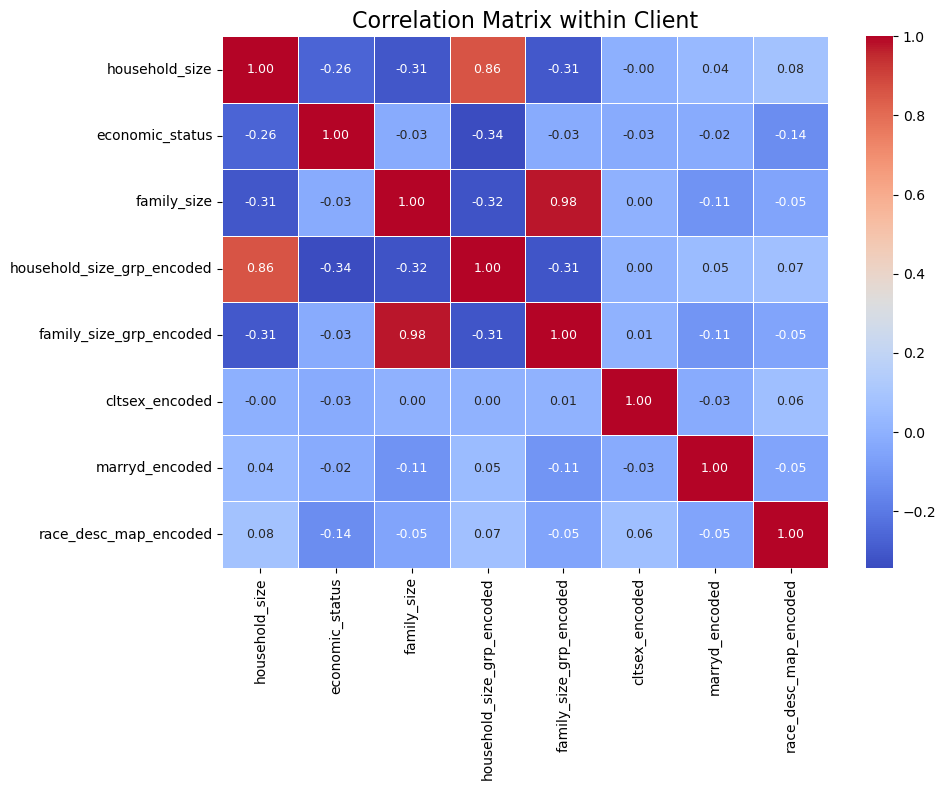

We can drop either the grouped column or its counterpart for client


In [134]:
# dfs["client_encode_test"].iloc[:,6:].head()
correlation_matrix = dfs["client_encoded"].iloc[:,3:].astype(float).corr()
plt.figure(figsize=(10, 8)) 
sns.heatmap(
    correlation_matrix,
    annot=True, 
    fmt=".2f",  
    cmap="coolwarm",
    linewidths=0.5,
    annot_kws={"size": 9} 
)
plt.title("Correlation Matrix within Client", fontsize=16)  
plt.tight_layout()  
plt.show()
print("We can drop either the grouped column or its counterpart for client")

In [135]:
dfs["client_encoded"].drop(columns=["family_size","household_size"], inplace=True) #drop these since clusters easier to classify (and less variations)

In [136]:
dfs["client_encoded"]["client_age"] = 2024 - dfs["client_encoded"]["cltdob"].dt.year

In [137]:
print("Initial Client df columns:", len(dfs["client"].columns), "vs. Encoded columns:",len(dfs["client_encoded"].columns))
print("Features in hh size:", len(dfs["client"]["household_size"].unique()), "vs. hh size grp:", len(dfs["client_encoded"]["household_size_grp_encoded"].unique()))

Initial Client df columns: 11 vs. Encoded columns: 10
Features in hh size: 348 vs. hh size grp: 6


<h2>EDA for Agents</h2>

In [138]:
pd.set_option('display.max_columns',None)
dfs["agent"].head()

,agntnum,agent_age,agent_gender,agent_marital,agent_tenure,cnt_converted,annual_premium_cnvrt,pct_lapsed,pct_cancel,pct_inforce,pct_prod_0_cnvrt,pct_prod_1_cnvrt,pct_prod_2_cnvrt,pct_prod_3_cnvrt,pct_prod_4_cnvrt,pct_prod_5_cnvrt,pct_prod_6_cnvrt,pct_prod_7_cnvrt,pct_prod_8_cnvrt,pct_prod_9_cnvrt,pct_SX0_unknown,pct_SX1_male,pct_SX2_female,pct_AG01_lt20,pct_AG02_20to24,pct_AG03_25to29,pct_AG04_30to34,pct_AG05_35to39,pct_AG06_40to44,pct_AG07_45to49,pct_AG08_50to54,pct_AG09_55to59,pct_AG10_60up,cluster,agent_product_expertise
0,AIN:9513,32.0,M,M,15.0,21.0,1.004900e+04,1.0,0.814954,0.000000,0.0,0.0,0.285714,0.0,0.523810,0.0,0.190476,0.0,0.000000,0.000000,0.0,0.333333,0.666667,0.000000,0.238095,0.142857,0.000000,0.000000,0.000000,0.000000,0.238095,0.142857,0.238095,3,"[prod_2, prod_6]"
1,AIN:4310,40.0,M,M,18.0,396.0,1.971080e+05,0.6,0.083937,0.429293,0.0,0.0,0.128788,0.0,0.005051,0.0,0.462121,0.0,0.292929,0.111111,0.0,0.601010,0.398990,0.012626,0.012626,0.131313,0.388889,0.116162,0.184343,0.083333,0.020202,0.040404,0.010101,6,[prod_6]
2,AIN:4302,39.0,F,M,40.0,853.0,5.106351e+05,0.3,0.017406,0.711606,0.0,0.0,0.242673,0.0,0.083236,0.0,0.436108,0.0,0.109027,0.128957,0.0,0.695193,0.304807,0.010551,0.030481,0.137163,0.144197,0.177022,0.311841,0.106682,0.036342,0.035170,0.010551,6,[prod_4]
3,AIN:4996,57.0,F,D,41.0,554.0,3.514724e+05,0.3,0.003623,0.584838,0.0,0.0,0.194946,0.0,0.083032,0.0,0.436823,0.0,0.061372,0.223827,0.0,0.397112,0.602888,0.018051,0.005415,0.009025,0.128159,0.108303,0.234657,0.162455,0.135379,0.160650,0.037906,6,"[prod_7, prod_9, prod_6, prod_0, prod_2]"
4,AIN:3457,38.0,M,M,62.0,1525.0,1.215380e+06,0.3,0.017523,0.640656,0.0,0.0,0.145574,0.0,0.047869,0.0,0.620328,0.0,0.114098,0.072131,0.0,0.626885,0.373115,0.013115,0.035410,0.069508,0.201311,0.215082,0.214426,0.108197,0.084590,0.043279,0.015082,6,"[prod_6, prod_8]"


In [139]:
dfs["agent"].head()

,agntnum,agent_age,agent_gender,agent_marital,agent_tenure,cnt_converted,annual_premium_cnvrt,pct_lapsed,pct_cancel,pct_inforce,pct_prod_0_cnvrt,pct_prod_1_cnvrt,pct_prod_2_cnvrt,pct_prod_3_cnvrt,pct_prod_4_cnvrt,pct_prod_5_cnvrt,pct_prod_6_cnvrt,pct_prod_7_cnvrt,pct_prod_8_cnvrt,pct_prod_9_cnvrt,pct_SX0_unknown,pct_SX1_male,pct_SX2_female,pct_AG01_lt20,pct_AG02_20to24,pct_AG03_25to29,pct_AG04_30to34,pct_AG05_35to39,pct_AG06_40to44,pct_AG07_45to49,pct_AG08_50to54,pct_AG09_55to59,pct_AG10_60up,cluster,agent_product_expertise
0,AIN:9513,32.0,M,M,15.0,21.0,1.004900e+04,1.0,0.814954,0.000000,0.0,0.0,0.285714,0.0,0.523810,0.0,0.190476,0.0,0.000000,0.000000,0.0,0.333333,0.666667,0.000000,0.238095,0.142857,0.000000,0.000000,0.000000,0.000000,0.238095,0.142857,0.238095,3,"[prod_2, prod_6]"
1,AIN:4310,40.0,M,M,18.0,396.0,1.971080e+05,0.6,0.083937,0.429293,0.0,0.0,0.128788,0.0,0.005051,0.0,0.462121,0.0,0.292929,0.111111,0.0,0.601010,0.398990,0.012626,0.012626,0.131313,0.388889,0.116162,0.184343,0.083333,0.020202,0.040404,0.010101,6,[prod_6]
2,AIN:4302,39.0,F,M,40.0,853.0,5.106351e+05,0.3,0.017406,0.711606,0.0,0.0,0.242673,0.0,0.083236,0.0,0.436108,0.0,0.109027,0.128957,0.0,0.695193,0.304807,0.010551,0.030481,0.137163,0.144197,0.177022,0.311841,0.106682,0.036342,0.035170,0.010551,6,[prod_4]
3,AIN:4996,57.0,F,D,41.0,554.0,3.514724e+05,0.3,0.003623,0.584838,0.0,0.0,0.194946,0.0,0.083032,0.0,0.436823,0.0,0.061372,0.223827,0.0,0.397112,0.602888,0.018051,0.005415,0.009025,0.128159,0.108303,0.234657,0.162455,0.135379,0.160650,0.037906,6,"[prod_7, prod_9, prod_6, prod_0, prod_2]"
4,AIN:3457,38.0,M,M,62.0,1525.0,1.215380e+06,0.3,0.017523,0.640656,0.0,0.0,0.145574,0.0,0.047869,0.0,0.620328,0.0,0.114098,0.072131,0.0,0.626885,0.373115,0.013115,0.035410,0.069508,0.201311,0.215082,0.214426,0.108197,0.084590,0.043279,0.015082,6,"[prod_6, prod_8]"


In [140]:
dfs["agent_encoded"] = dfs["agent"].copy()


for col in ["agent_gender", "agent_marital"]: 
    encoder = LabelEncoder()
    dfs["agent_encoded"][f"{col}_encoded"] = encoder.fit_transform(dfs["agent_encoded"][col])

# Define bins and labels for `agent_tenure` (to match customer tenure format)
bins = [0, 5, 15, 40, dfs["agent_encoded"]["agent_tenure"].max()]  # Define logical breakpoints
labels = ["TNR2_lt5yr", "TNR3_5to15yr", "TNR4_15to40yr", "TNR5_40yrup"]  # Categories aligned with customer tenure


dfs["agent_encoded"]["agent_tenure_grp"] = pd.cut(dfs["agent_encoded"]["agent_tenure"], bins=bins, labels=labels)


dfs["agent_encoded"]["agent_tenure_grp"] = dfs["agent_encoded"]["agent_tenure_grp"].astype("category")


dfs["agent_encoded"]["agent_tenure_grp"] = dfs["agent_encoded"]["agent_tenure_grp"].cat.add_categories(["Unknown"]).fillna("Unknown")


encoder = OrdinalEncoder(categories=[["Unknown", "TNR2_lt5yr", "TNR3_5to15yr", "TNR4_15to40yr", "TNR5_40yrup"]])
dfs["agent_encoded"]["agent_tenure_grp_encoded"] = encoder.fit_transform(dfs["agent_encoded"][["agent_tenure_grp"]])





In [141]:
dfs["agent_encoded"].head()

,agntnum,agent_age,agent_gender,agent_marital,agent_tenure,cnt_converted,annual_premium_cnvrt,pct_lapsed,pct_cancel,pct_inforce,pct_prod_0_cnvrt,pct_prod_1_cnvrt,pct_prod_2_cnvrt,pct_prod_3_cnvrt,pct_prod_4_cnvrt,pct_prod_5_cnvrt,pct_prod_6_cnvrt,pct_prod_7_cnvrt,pct_prod_8_cnvrt,pct_prod_9_cnvrt,pct_SX0_unknown,pct_SX1_male,pct_SX2_female,pct_AG01_lt20,pct_AG02_20to24,pct_AG03_25to29,pct_AG04_30to34,pct_AG05_35to39,pct_AG06_40to44,pct_AG07_45to49,pct_AG08_50to54,pct_AG09_55to59,pct_AG10_60up,cluster,agent_product_expertise,agent_gender_encoded,agent_marital_encoded,agent_tenure_grp,agent_tenure_grp_encoded
0,AIN:9513,32.0,M,M,15.0,21.0,1.004900e+04,1.0,0.814954,0.000000,0.0,0.0,0.285714,0.0,0.523810,0.0,0.190476,0.0,0.000000,0.000000,0.0,0.333333,0.666667,0.000000,0.238095,0.142857,0.000000,0.000000,0.000000,0.000000,0.238095,0.142857,0.238095,3,"[prod_2, prod_6]",1,1,TNR3_5to15yr,2.0
1,AIN:4310,40.0,M,M,18.0,396.0,1.971080e+05,0.6,0.083937,0.429293,0.0,0.0,0.128788,0.0,0.005051,0.0,0.462121,0.0,0.292929,0.111111,0.0,0.601010,0.398990,0.012626,0.012626,0.131313,0.388889,0.116162,0.184343,0.083333,0.020202,0.040404,0.010101,6,[prod_6],1,1,TNR4_15to40yr,3.0
2,AIN:4302,39.0,F,M,40.0,853.0,5.106351e+05,0.3,0.017406,0.711606,0.0,0.0,0.242673,0.0,0.083236,0.0,0.436108,0.0,0.109027,0.128957,0.0,0.695193,0.304807,0.010551,0.030481,0.137163,0.144197,0.177022,0.311841,0.106682,0.036342,0.035170,0.010551,6,[prod_4],0,1,TNR4_15to40yr,3.0
3,AIN:4996,57.0,F,D,41.0,554.0,3.514724e+05,0.3,0.003623,0.584838,0.0,0.0,0.194946,0.0,0.083032,0.0,0.436823,0.0,0.061372,0.223827,0.0,0.397112,0.602888,0.018051,0.005415,0.009025,0.128159,0.108303,0.234657,0.162455,0.135379,0.160650,0.037906,6,"[prod_7, prod_9, prod_6, prod_0, prod_2]",0,0,TNR5_40yrup,4.0
4,AIN:3457,38.0,M,M,62.0,1525.0,1.215380e+06,0.3,0.017523,0.640656,0.0,0.0,0.145574,0.0,0.047869,0.0,0.620328,0.0,0.114098,0.072131,0.0,0.626885,0.373115,0.013115,0.035410,0.069508,0.201311,0.215082,0.214426,0.108197,0.084590,0.043279,0.015082,6,"[prod_6, prod_8]",1,1,TNR5_40yrup,4.0


Final selected columns: ['pct_prod_0_cnvrt', 'pct_prod_1_cnvrt', 'pct_prod_2_cnvrt', 'pct_prod_3_cnvrt', 'pct_prod_4_cnvrt', 'pct_prod_5_cnvrt', 'pct_prod_6_cnvrt', 'pct_prod_7_cnvrt', 'pct_prod_8_cnvrt', 'pct_prod_9_cnvrt', 'cluster', 'agent_tenure']


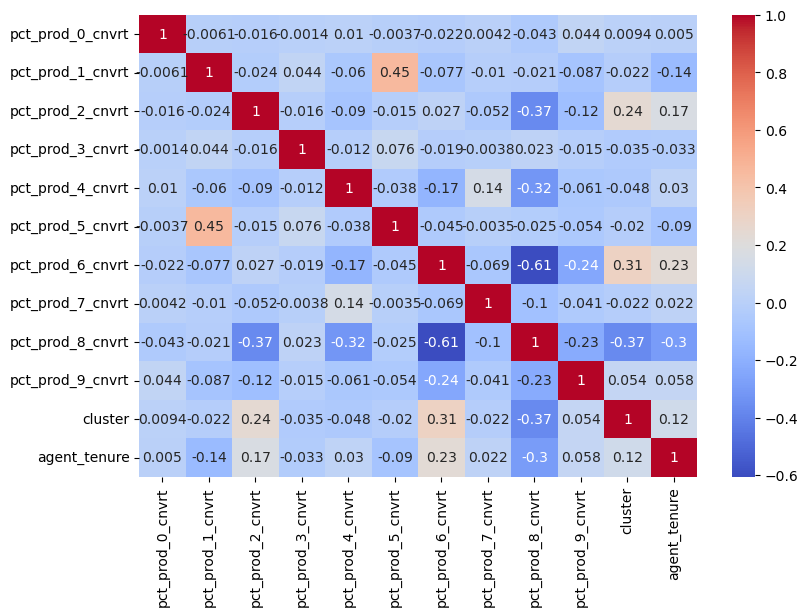

In [142]:
products_cnvrt = [f"pct_prod_{i}_cnvrt" for i in range(0, 10)]

#check if 'cluster' and 'agent_tenure' exist in the DataFrame before adding
if "cluster" in dfs["agent_encoded"].columns:
    products_cnvrt.append("cluster")
if "agent_tenure" in dfs["agent_encoded"].columns:
    products_cnvrt.append("agent_tenure")

print("Final selected columns:", products_cnvrt)

#compute the correlation matrix only for existing columns
correlation_matrix = dfs["agent_encoded"].loc[:, products_cnvrt].corr()

#plot the heatmap
plt.figure(figsize=(9,6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.show()


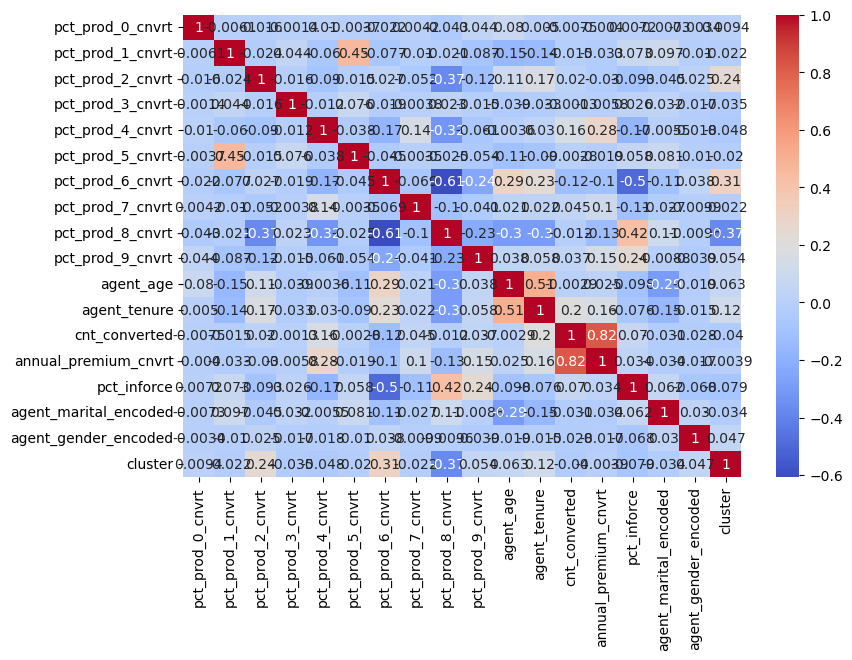

In [143]:

products_cnvrt = [f"pct_prod_{i}_cnvrt" for i in range(0, 10)]
products_cnvrt += ["agent_age", "agent_tenure", "cnt_converted", "annual_premium_cnvrt",
                   "pct_inforce", "agent_marital_encoded", "agent_gender_encoded", "cluster"]

#check which columns actually exist
existing_columns = dfs["agent_encoded"].columns
valid_columns = [col for col in products_cnvrt if col in existing_columns]

#print missing columns (for debugging)
missing_columns = set(products_cnvrt) - set(valid_columns)
if missing_columns:
    print(f"⚠️ Warning: The following columns are missing and will be ignored: {missing_columns}")

#compute correlation matrix only for valid columns
correlation_matrix = dfs["agent_encoded"].loc[:, valid_columns].corr()

#plot the heatmap
plt.figure(figsize=(9, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.show()


In [144]:
print("Indices of Age-based cnvrt:",list(dfs["agent_encoded"].columns).index("pct_AG01_lt20"),":", list(dfs["agent_encoded"].columns).index('pct_AG10_60up'))

Indices of Age-based cnvrt: 23 : 32


In [145]:
age_cnvrt_df = dfs["agent_encoded"].iloc[:,21:30]
age_cnvrt_df["age_total_cnvrt"] = age_cnvrt_df.sum(axis=1)
age_cnvrt_df["agent_age"] = dfs["agent_encoded"]["agent_age"]
age_cnvrt_df["cluster"] = dfs["agent_encoded"]["cluster"]


<Axes: >

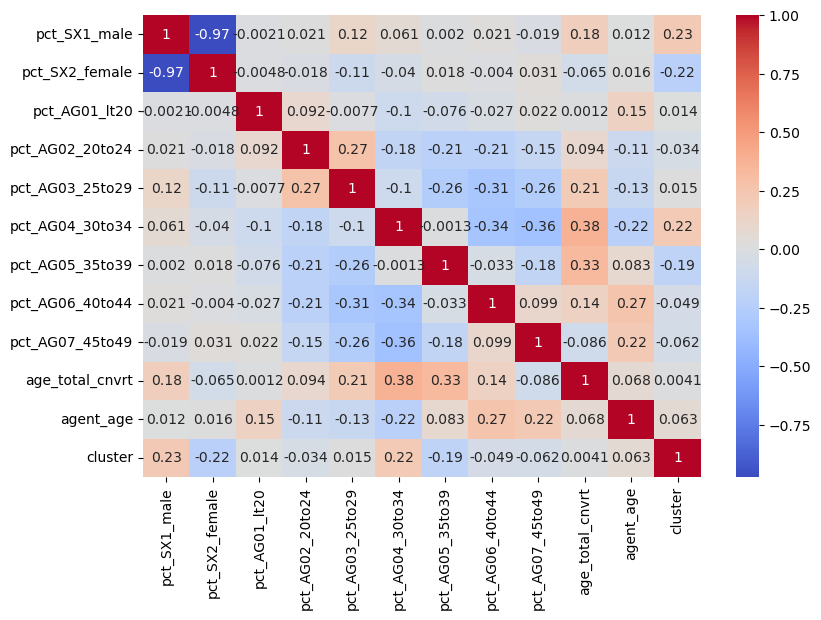

In [146]:
correlation_matrix = age_cnvrt_df.corr()

plt.figure(figsize=(9,6))
sns.heatmap(correlation_matrix,
            annot=True,
            cmap="coolwarm")

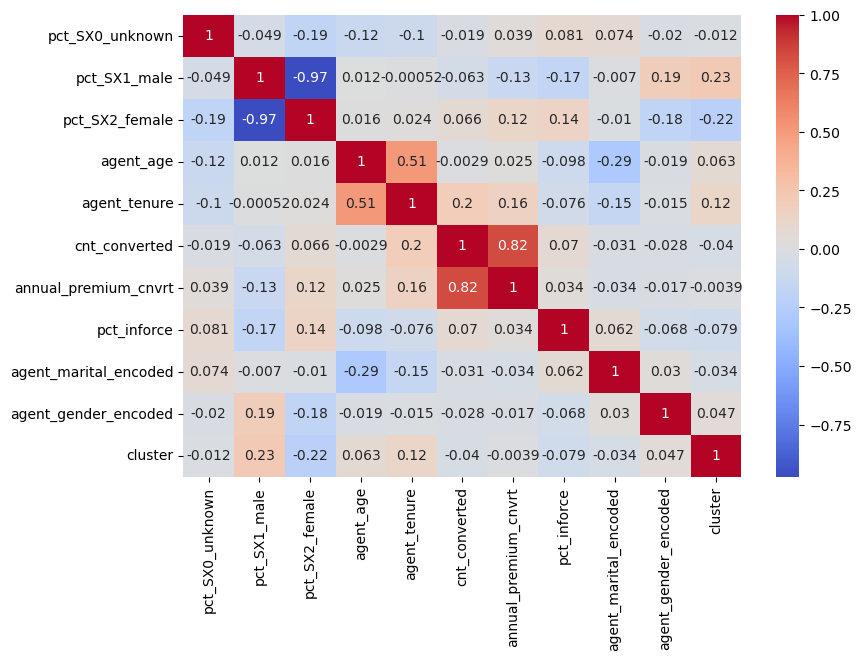

In [147]:
pct_sex = ["pct_SX0_unknown", "pct_SX1_male", "pct_SX2_female",
           "agent_age", "agent_tenure", "cnt_converted", "annual_premium_cnvrt",
           "pct_inforce", "agent_marital_encoded", "agent_gender_encoded", "cluster"]

#get existing columns from the dataframe
existing_columns = dfs["agent_encoded"].columns

#filter only valid columns
valid_columns = [col for col in pct_sex if col in existing_columns]

#print missing columns for debugging
missing_columns = set(pct_sex) - set(valid_columns)
if missing_columns:
    print(f"⚠️ Warning: The following columns are missing and will be ignored: {missing_columns}")

#compute correlation matrix only for valid columns
correlation_matrix = dfs["agent_encoded"].loc[:, valid_columns].corr()

#plot the heatmap
plt.figure(figsize=(9, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.show()


In [148]:
dfs["agent_encoded"].drop(columns=["pct_SX2_female"],inplace=True) #drop one gender column since high corr

In [149]:
pdts_in_policy_df = dfs["policy"]["product"].unique()
print(len(pdts_in_policy_df), pdts_in_policy_df)

7 ['prod_8' 'prod_6' 'prod_4' 'prod_2' 'prod_9' 'prod_7' 'prod_0']


In [150]:
#Product 1 and 3 cld be dropped
dfs["agent"][[f"pct_prod_{i}_cnvrt" for i in range(0,10)]].sum(axis=0) 

pct_prod_0_cnvrt       5.881897
pct_prod_1_cnvrt     101.835524
pct_prod_2_cnvrt    1010.831442
pct_prod_3_cnvrt       1.866970
pct_prod_4_cnvrt     815.009106
pct_prod_5_cnvrt      19.936241
pct_prod_6_cnvrt    2165.998331
pct_prod_7_cnvrt      75.845880
pct_prod_8_cnvrt    4732.991273
pct_prod_9_cnvrt    1188.468118
dtype: float64

In [151]:
dfs["agent_encoded"].drop(columns=["pct_lapsed"],inplace=True)

In [152]:
dfs["agent_encoded"]

,agntnum,agent_age,agent_gender,agent_marital,agent_tenure,cnt_converted,annual_premium_cnvrt,pct_cancel,pct_inforce,pct_prod_0_cnvrt,pct_prod_1_cnvrt,pct_prod_2_cnvrt,pct_prod_3_cnvrt,pct_prod_4_cnvrt,pct_prod_5_cnvrt,pct_prod_6_cnvrt,pct_prod_7_cnvrt,pct_prod_8_cnvrt,pct_prod_9_cnvrt,pct_SX0_unknown,pct_SX1_male,pct_AG01_lt20,pct_AG02_20to24,pct_AG03_25to29,pct_AG04_30to34,pct_AG05_35to39,pct_AG06_40to44,pct_AG07_45to49,pct_AG08_50to54,pct_AG09_55to59,pct_AG10_60up,cluster,agent_product_expertise,agent_gender_encoded,agent_marital_encoded,agent_tenure_grp,agent_tenure_grp_encoded
0,AIN:9513,32.0,M,M,15.0,21.0,1.004900e+04,0.814954,0.000000,0.00000,0.0,0.285714,0.0,0.523810,0.0,0.190476,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.238095,0.142857,0.000000,0.000000,0.000000,0.000000,0.238095,0.142857,0.238095,3,"[prod_2, prod_6]",1,1,TNR3_5to15yr,2.0
1,AIN:4310,40.0,M,M,18.0,396.0,1.971080e+05,0.083937,0.429293,0.00000,0.0,0.128788,0.0,0.005051,0.0,0.462121,0.000000,0.292929,0.111111,0.000000,0.601010,0.012626,0.012626,0.131313,0.388889,0.116162,0.184343,0.083333,0.020202,0.040404,0.010101,6,[prod_6],1,1,TNR4_15to40yr,3.0
2,AIN:4302,39.0,F,M,40.0,853.0,5.106351e+05,0.017406,0.711606,0.00000,0.0,0.242673,0.0,0.083236,0.0,0.436108,0.000000,0.109027,0.128957,0.000000,0.695193,0.010551,0.030481,0.137163,0.144197,0.177022,0.311841,0.106682,0.036342,0.035170,0.010551,6,[prod_4],0,1,TNR4_15to40yr,3.0
3,AIN:4996,57.0,F,D,41.0,554.0,3.514724e+05,0.003623,0.584838,0.00000,0.0,0.194946,0.0,0.083032,0.0,0.436823,0.000000,0.061372,0.223827,0.000000,0.397112,0.018051,0.005415,0.009025,0.128159,0.108303,0.234657,0.162455,0.135379,0.160650,0.037906,6,"[prod_7, prod_9, prod_6, prod_0, prod_2]",0,0,TNR5_40yrup,4.0
4,AIN:3457,38.0,M,M,62.0,1525.0,1.215380e+06,0.017523,0.640656,0.00000,0.0,0.145574,0.0,0.047869,0.0,0.620328,0.000000,0.114098,0.072131,0.000000,0.626885,0.013115,0.035410,0.069508,0.201311,0.215082,0.214426,0.108197,0.084590,0.043279,0.015082,6,"[prod_6, prod_8]",1,1,TNR5_40yrup,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10124,AIN:2805,34.0,F,U,57.0,176.0,3.547658e+05,0.022383,0.812500,0.00000,0.0,0.000000,0.0,0.977273,0.0,0.000000,0.022727,0.000000,0.000000,0.000000,0.267045,0.090909,0.051136,0.142045,0.136364,0.034091,0.125000,0.130682,0.079545,0.193182,0.017045,4,"[prod_8, prod_8, prod_4, prod_2, prod_2, prod_2]",0,3,TNR5_40yrup,4.0
10125,AIN:6195,33.0,M,S,31.0,28.0,6.802000e+03,0.000000,0.392857,0.00000,0.0,0.107143,0.0,0.000000,0.0,0.892857,0.000000,0.000000,0.000000,0.000000,0.535714,0.000000,0.071429,0.142857,0.392857,0.000000,0.107143,0.250000,0.035714,0.000000,0.000000,6,"[prod_0, prod_0]",1,2,TNR4_15to40yr,3.0
10126,AIN:8096,45.0,M,M,54.0,124.0,4.683500e+04,0.000000,0.362903,0.00000,0.0,0.024194,0.0,0.000000,0.0,0.975806,0.000000,0.000000,0.000000,0.000000,0.637097,0.024194,0.072581,0.096774,0.387097,0.088710,0.072581,0.104839,0.129032,0.024194,0.000000,9,"[prod_6, prod_7, prod_9, prod_9, prod_7]",1,1,TNR5_40yrup,4.0
10127,AIN:389,55.0,F,M,119.0,2303.0,8.047220e+05,0.000874,0.000000,0.00000,0.0,0.000000,0.0,0.996092,0.0,0.003908,0.000000,0.000000,0.000000,0.000000,0.323491,0.037343,0.148502,0.150673,0.141989,0.145462,0.140252,0.124620,0.082067,0.028224,0.000868,3,"[prod_7, prod_2, prod_0, prod_7, prod_9, prod_8]",0,1,TNR5_40yrup,4.0


<h2>EDA for Policy</h2>

In [153]:
dfs["policy"].head()

,chdrnum,agntnum,secuityno,occdate,annual_premium,product,flg_main,flg_rider,flg_inforce,flg_lapsed,flg_cancel,flg_expire,flg_converted,product_grp,cust_age_at_purchase_grp,cust_tenure_at_purchase_grp
0,PID:281,AIN:62,CIN:6957,2018-11-12,0.0,prod_8,1,0,1,0,0,0,1,PG:0,AG05_35to39,TNR2_lt1yr
1,PID:280,AIN:63,CIN:2161,2024-02-22,7.0,prod_8,1,0,1,0,0,0,1,PG:0,AG04_30to34,TNR4_4to8yr
2,PID:2577,AIN:63,CIN:16605,2024-08-28,423.0,prod_6,1,0,1,0,0,0,1,PG:0,AG08_50to54,TNR5_8yrup
3,PID:2578,AIN:63,CIN:16605,2024-08-27,217.0,prod_6,1,0,1,0,0,0,1,PG:0,AG08_50to54,TNR5_8yrup
4,PID:305,AIN:63,CIN:7917,2024-08-28,432.0,prod_6,1,0,1,0,0,0,1,PG:0,AG07_45to49,TNR4_4to8yr


In [154]:
policy_df = dfs["policy"].copy()
policy_df["cust_tenure_at_purchase_grp"].unique()

encoder = OrdinalEncoder(categories=[['TNR2_lt1yr', 'TNR3_1to4yr','TNR4_4to8yr','TNR5_8yrup']])
policy_df["cust_tenure_at_purchase_grp_encoded"] = encoder.fit_transform(policy_df[["cust_tenure_at_purchase_grp"]])
policy_df.drop(columns=["cust_tenure_at_purchase_grp"],inplace=True)

encoder = OrdinalEncoder(categories=[['AG05_35to39', 'AG04_30to34', 'AG08_50to54', 'AG07_45to49',
       'AG09_55to59', 'AG06_40to44', 'AG10_60up', 'AG03_25to29',
       'AG02_20to24', 'AG01_lt20', 'AG00_missing']])
policy_df["cust_age_at_purchase_grp_encoded"] = encoder.fit_transform(policy_df[["cust_age_at_purchase_grp"]])
policy_df.drop(columns=["cust_age_at_purchase_grp"],inplace=True)
policy_df.head()

policy_df["product"] = policy_df["product"].apply(lambda x: float(x[-1]))
policy_df["product_grp"] = policy_df["product_grp"].apply(lambda x: float(x[-1]))
policy_df.head()

,chdrnum,agntnum,secuityno,occdate,annual_premium,product,flg_main,flg_rider,flg_inforce,flg_lapsed,flg_cancel,flg_expire,flg_converted,product_grp,cust_tenure_at_purchase_grp_encoded,cust_age_at_purchase_grp_encoded
0,PID:281,AIN:62,CIN:6957,2018-11-12,0.0,8.0,1,0,1,0,0,0,1,0.0,0.0,0.0
1,PID:280,AIN:63,CIN:2161,2024-02-22,7.0,8.0,1,0,1,0,0,0,1,0.0,2.0,1.0
2,PID:2577,AIN:63,CIN:16605,2024-08-28,423.0,6.0,1,0,1,0,0,0,1,0.0,3.0,2.0
3,PID:2578,AIN:63,CIN:16605,2024-08-27,217.0,6.0,1,0,1,0,0,0,1,0.0,3.0,2.0
4,PID:305,AIN:63,CIN:7917,2024-08-28,432.0,6.0,1,0,1,0,0,0,1,0.0,2.0,3.0


In [155]:
dfs["policy_encoded"] = policy_df.copy()

In [156]:
df_merged = pd.merge(dfs['policy_encoded'], dfs['client_encoded'], on='secuityno', how='inner')

df_merged = pd.merge(df_merged, dfs['agent_encoded'], on='agntnum', how='inner')

In [157]:
df_merged.head()

,chdrnum,agntnum,secuityno,occdate,annual_premium,product,flg_main,flg_rider,flg_inforce,flg_lapsed,flg_cancel,flg_expire,flg_converted,product_grp,cust_tenure_at_purchase_grp_encoded,cust_age_at_purchase_grp_encoded,cltdob,cltpcode,economic_status,household_size_grp_encoded,family_size_grp_encoded,cltsex_encoded,marryd_encoded,race_desc_map_encoded,client_age,agent_age,agent_gender,agent_marital,agent_tenure,cnt_converted,annual_premium_cnvrt,pct_cancel,pct_inforce,pct_prod_0_cnvrt,pct_prod_1_cnvrt,pct_prod_2_cnvrt,pct_prod_3_cnvrt,pct_prod_4_cnvrt,pct_prod_5_cnvrt,pct_prod_6_cnvrt,pct_prod_7_cnvrt,pct_prod_8_cnvrt,pct_prod_9_cnvrt,pct_SX0_unknown,pct_SX1_male,pct_AG01_lt20,pct_AG02_20to24,pct_AG03_25to29,pct_AG04_30to34,pct_AG05_35to39,pct_AG06_40to44,pct_AG07_45to49,pct_AG08_50to54,pct_AG09_55to59,pct_AG10_60up,cluster,agent_product_expertise,agent_gender_encoded,agent_marital_encoded,agent_tenure_grp,agent_tenure_grp_encoded
0,PID:281,AIN:62,CIN:6957,2018-11-12,0.0,8.0,1,0,1,0,0,0,1,0.0,0.0,0.0,1982-03-11,648146,78,1.0,5.0,0,1,0,42,31.0,M,S,6.0,47.0,6112.000,0.243689,0.936170,0.0,0.212766,0.319149,0.0,0.000000,0.000000,0.042553,0.000000,0.425532,0.00000,0.042553,0.531915,0.000000,0.000000,0.106383,0.148936,0.297872,0.148936,0.191489,0.000000,0.000000,0.000000,1,"[prod_9, prod_2, prod_0, prod_0]",1,2,TNR3_5to15yr,2.0
1,PID:280,AIN:63,CIN:2161,2024-02-22,7.0,8.0,1,0,1,0,0,0,1,0.0,2.0,1.0,1991-03-18,680120,31,2.0,3.0,1,3,0,33,32.0,M,S,71.0,4560.0,1045929.756,0.157312,0.854605,0.0,0.041009,0.051974,0.0,0.010307,0.033333,0.063596,0.007237,0.761404,0.03114,0.024561,0.605263,0.009649,0.022149,0.050439,0.260307,0.212719,0.181360,0.121711,0.071711,0.019956,0.011842,1,"[prod_0, prod_9, prod_9, prod_6, prod_0, prod_...",1,2,TNR5_40yrup,4.0
2,PID:2577,AIN:63,CIN:16605,2024-08-28,423.0,6.0,1,0,1,0,0,0,1,0.0,3.0,2.0,1973-04-16,640818,30,2.0,4.0,1,1,0,51,32.0,M,S,71.0,4560.0,1045929.756,0.157312,0.854605,0.0,0.041009,0.051974,0.0,0.010307,0.033333,0.063596,0.007237,0.761404,0.03114,0.024561,0.605263,0.009649,0.022149,0.050439,0.260307,0.212719,0.181360,0.121711,0.071711,0.019956,0.011842,1,"[prod_0, prod_9, prod_9, prod_6, prod_0, prod_...",1,2,TNR5_40yrup,4.0
3,PID:2578,AIN:63,CIN:16605,2024-08-27,217.0,6.0,1,0,1,0,0,0,1,0.0,3.0,2.0,1973-04-16,640818,30,2.0,4.0,1,1,0,51,32.0,M,S,71.0,4560.0,1045929.756,0.157312,0.854605,0.0,0.041009,0.051974,0.0,0.010307,0.033333,0.063596,0.007237,0.761404,0.03114,0.024561,0.605263,0.009649,0.022149,0.050439,0.260307,0.212719,0.181360,0.121711,0.071711,0.019956,0.011842,1,"[prod_0, prod_9, prod_9, prod_6, prod_0, prod_...",1,2,TNR5_40yrup,4.0
4,PID:305,AIN:63,CIN:7917,2024-08-28,432.0,6.0,1,0,1,0,0,0,1,0.0,2.0,3.0,1978-06-20,760401,00,1.0,3.0,0,1,2,46,32.0,M,S,71.0,4560.0,1045929.756,0.157312,0.854605,0.0,0.041009,0.051974,0.0,0.010307,0.033333,0.063596,0.007237,0.761404,0.03114,0.024561,0.605263,0.009649,0.022149,0.050439,0.260307,0.212719,0.181360,0.121711,0.071711,0.019956,0.011842,1,"[prod_0, prod_9, prod_9, prod_6, prod_0, prod_...",1,2,TNR5_40yrup,4.0


In [158]:
[i for i in list(df_merged.columns) if "encoded" in i]

['cust_tenure_at_purchase_grp_encoded',
 'cust_age_at_purchase_grp_encoded',
 'household_size_grp_encoded',
 'family_size_grp_encoded',
 'cltsex_encoded',
 'marryd_encoded',
 'race_desc_map_encoded',
 'agent_gender_encoded',
 'agent_marital_encoded',
 'agent_tenure_grp_encoded']

In [159]:
#drop unnecessary columns
df_final = df_merged.drop(columns=["occdate","chdrnum", "secuityno", "cluster","cltdob"])

#define target variable (y) and feature variables (X)
y = df_final["agntnum"]  # Target: Agent ID
X = df_final.drop(columns=["agntnum"])  # Features
X_train_resampled, X_test, y_train_resampled, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#encode categorical variables
categorical_cols = [
    "agent_gender_encoded", "agent_marital_encoded", "product", "product_grp",
    "cust_age_at_purchase_grp_encoded", "cust_tenure_at_purchase_grp_encoded", "cltsex_encoded",
    "marryd_encoded", "race_desc_map_encoded", "household_size_grp_encoded", "family_size_grp_encoded",
    "pct_SX1_male",
]

#scale numerical features
scaler = StandardScaler()
numerical_cols = [
    "agent_age", "agent_tenure", "cnt_converted", "annual_premium_cnvrt",
     "pct_cancel", "pct_inforce", "annual_premium", "pct_AG01_lt20",	
     "pct_AG02_20to24",	"pct_AG03_25to29",	"pct_AG04_30to34",	"pct_AG05_35to39",	
     "pct_AG06_40to44",	"pct_AG07_45to49",	"pct_AG08_50to54",	"pct_AG09_55to59",	
     "pct_AG10_60up"
]
numerical_cols += [f"pct_prod_{i}_cnvrt" for i in range(0,10)]
X_train_resampled[numerical_cols] = scaler.fit_transform(X_train_resampled[numerical_cols])

scaler = StandardScaler()
X_test[numerical_cols] = scaler.fit_transform(X_test[numerical_cols])
#check which numerical columns exist
existing_numerical_cols = [col for col in numerical_cols if col in X_train_resampled.columns]

#print missing columns for debugging
missing_cols = set(numerical_cols) - set(existing_numerical_cols)
if missing_cols:
    print(f"⚠️ Warning: The following numerical columns are missing and will be ignored: {missing_cols}")

X_train_resampled[existing_numerical_cols] = X_train_resampled[existing_numerical_cols].apply(pd.to_numeric, errors='coerce')
X_test[existing_numerical_cols] = X_test[existing_numerical_cols].apply(pd.to_numeric, errors='coerce')


scaler = StandardScaler()
X_train_resampled[existing_numerical_cols] = scaler.fit_transform(X_train_resampled[existing_numerical_cols])

existing_test_cols = [col for col in existing_numerical_cols if col in X_test.columns]
X_test[existing_test_cols] = scaler.transform(X_test[existing_test_cols])



In [160]:
scaler = MinMaxScaler()
#compute customer and advisor weights
df_merged["customer_weight"] = df_merged["cust_tenure_at_purchase_grp_encoded"] / df_merged["cust_tenure_at_purchase_grp_encoded"].max()
df_merged["advisor_weight"] = df_merged["agent_tenure_grp_encoded"] / df_merged["agent_tenure_grp_encoded"].max()

#normalize advisor performance (`annual_premium_cnvrt`)
df_merged["performance_weight"] = df_merged["annual_premium_cnvrt"] / df_merged["annual_premium_cnvrt"].max()

#compute engineered pct_inforce_score
df_merged["pct_inforce_score"] = (
    df_merged["pct_inforce"] *
    (df_merged["customer_weight"] + df_merged["advisor_weight"]) *
    df_merged["performance_weight"]
)

#normalize the interaction score for SVD
df_merged["pct_inforce_score"] = scaler.fit_transform(df_merged[["pct_inforce_score"]])



In [ ]:
# #Random Forest prior to new encoding: 
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score, classification_report
# # Initialize Random Forest Classifier
# rf_model = RandomForestClassifier(
#     n_estimators=100,  
#     max_depth=20,    
#     random_state=42,
#     n_jobs=-1  
# )

# # Train the model on undersampled data
# rf_model.fit(X_train_resampled, y_train_resampled)
# # Predict on test set
# y_pred = rf_model.predict(X_test)

# # Print accuracy
# accuracy = accuracy_score(y_test, y_pred)
# print(f"Random Forest Accuracy: {accuracy:.4f}")

# # Print classification report
# print("\nClassification Report:")
# print(classification_report(y_test, y_pred))

Random Forest Accuracy: 0.5488
Classification Report
<table>
<thead>
<td></td><td>precision</td><td>recall</td><td>f1-score</td><td>support</td>
</th>
</thead>
<tbody>
<tr>
<td>accuracy</td><td></td><td></td><td>0.55</td><td>5794</td>
</tr>
<tr><td>macro avg</td><td>0.4</td><td>0.42</td><td>0.41</td><td>5794</td></tr>
<tr><td>weighted avg</td><td>0.52</td><td>0.55</td><td>0.53</td><td>5794</td>
</tbody>
</table>


In [161]:
reader = Reader(rating_scale=(0, 1))

data = Dataset.load_from_df(df_merged[['secuityno', 'agntnum', 'pct_inforce_score']], reader)

#convert your existing train-test split into Surprise format
trainset = data.build_full_trainset()  #use all data to train
testset = trainset.build_testset()  #generate testset for evaluation
model = SVD(n_factors=100, n_epochs=20, random_state=42)
model.fit(trainset)
model = SVD(n_factors=100, n_epochs=20, random_state=42)
model.fit(trainset)
predictions = model.test(testset)
# RMSE (Root Mean Square Error)
rmse_score = accuracy.rmse(predictions)

# MAE (Mean Absolute Error)
mae_score = accuracy.mae(predictions)


RMSE: 0.0501
MAE:  0.0327


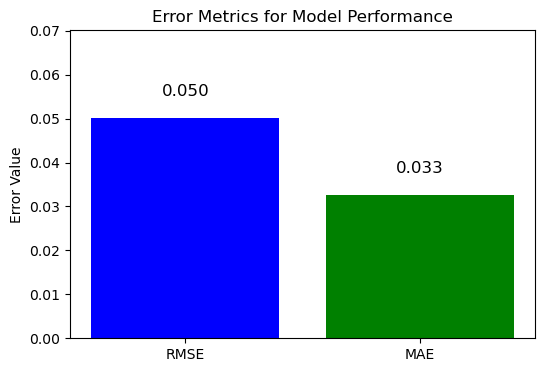

In [162]:
rmse_score = 0.0501
mae_score = 0.0327  

#labels and values
metrics = ['RMSE', 'MAE']
values = [rmse_score, mae_score]

#plot
plt.figure(figsize=(6, 4))
plt.bar(metrics, values, color=['blue', 'green'])
plt.ylabel('Error Value')
plt.title('Error Metrics for Model Performance')
plt.ylim(0, max(values) + 0.02)

#display values on bars
for i, v in enumerate(values):
    plt.text(i, v + 0.005, f'{v:.3f}', ha='center', fontsize=12)

plt.show()

In [163]:
reader = Reader(rating_scale=(0, 1))  #binary interaction (1 = active, 0 = inactive)

data = Dataset.load_from_df(df_merged[['secuityno', 'agntnum', 'pct_inforce']], reader)

#convert dataset into Surprise format
trainset = data.build_full_trainset()  #use all data to train
testset = trainset.build_testset()  #generate testset for evaluation

#SVD model
model = SVD(n_factors=100, n_epochs=20, random_state=42)
model.fit(trainset)

#predict on test set
predictions = model.test(testset)

#convert predictions into a DataFrame
pred_df = pd.DataFrame([(pred.uid, pred.iid, pred.est) for pred in predictions],
                       columns=['secuityno', 'agntnum_pred', 'predicted_rating'])

df_merged_xgb = df_merged.merge(pred_df, on=['secuityno'], how='left')

# Check if there are missing predictions
df_merged_xgb.dropna(subset=['predicted_rating'], inplace=True)

#remove Rare Agents (Less Than 2 Occurrences)**
agent_counts = df_merged_xgb['agntnum'].value_counts()
df_merged_xgb = df_merged_xgb[df_merged_xgb['agntnum'].isin(agent_counts[agent_counts > 1].index)]
print(f"Removed {agent_counts[agent_counts == 1].shape[0]} agents with only 1 occurrence.")

#ensure categorical variables exist in the dataset before using them
existing_features = [col for col in ['predicted_rating', 'product_grp', 'cust_age_at_purchase_grp_encoded',
                                     'cust_tenure_at_purchase_grp_encoded', 'cluster']
                     if col in df_merged_xgb.columns]

print("Using the following features for training:", existing_features)

#encode categorical variables
df_merged_xgb[existing_features] = df_merged_xgb[existing_features].astype('category').apply(lambda x: x.cat.codes)

X = df_merged_xgb[existing_features]
y = df_merged_xgb['agntnum']  # Do NOT encode `y` yet

#split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#encode `y_train` and `y_test`
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)  # Ensure `y_test` follows `y_train` mapping

#ensure `y_test` Contains Only Labels Present in `y_train`**
valid_classes = set(y_train_encoded)
mask = np.isin(y_test_encoded, list(valid_classes))  # Filter `y_test` for valid labels
X_test, y_test_encoded = X_test[mask], y_test_encoded[mask] 

print(f"Adjusted y_test size: {len(y_test_encoded)} (Removed invalid agent labels)")

#train XGBoost
xgb_model = xgb.XGBClassifier(n_estimators=20, learning_rate=0.1, max_depth=6, random_state=42, tree_method = 'hist')
xgb_model.fit(X_train, y_train_encoded)

y_pred = xgb_model.predict(X_test)

#evaluate model performance
accuracy = accuracy_score(y_test_encoded, y_pred)
print(f"XGBoost Model Accuracy: {accuracy:.4f}")
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

#MAE (Mean Absolute Error)
mae = mean_absolute_error(y_test_encoded, y_pred)

#RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_test_encoded, y_pred))

# Print results
mae, rmse



Removed 3379 agents with only 1 occurrence.
Using the following features for training: ['predicted_rating', 'product_grp', 'cust_age_at_purchase_grp_encoded', 'cust_tenure_at_purchase_grp_encoded', 'cluster']
Adjusted y_test size: 12175 (Removed invalid agent labels)
XGBoost Model Accuracy: 0.4397


(1184.7741273100617, 1981.0176859257765)